In [3]:
#!pip install scipy
#!pip3 uninstall scikit-learn --yes
#!pip3 install scikit-learn==0.22
#!pip install iterative-stratification

In [5]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from operator import add
import numpy as np
import json
import os

1. X = 각 image
2. Y = image에 존재하는 label

- image id에 대응하는 annotation label값을 모두 Y에 저장
    - len(X)=len(Y)= 데이터 개수
    
- skfold로 label을 균등하게 나눈 index값을 구함

- index = image_id이므로 해당 image_id를 가진 image와 annotations들을 모아서 값을 저장

In [6]:
annos_path = 'train.json'
with open(annos_path, 'rt', encoding='UTF-8') as annotations:
        coco = json.load(annotations)
        info = coco['info']
        licenses = coco['licenses']
        images = coco['images']
        annotations = coco['annotations']
        categories = coco['categories']

In [94]:
X = coco['images']
Y = [ [0]*len(categories) for _ in range(len(images))]

for anno in annotations:
    image_id = anno['image_id']
    Y[image_id][anno['category_id']]+=1

In [95]:
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=1010)

### 제대로 분류되는지 확인

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

label_nums =np.array([[0]*len(categories) for _ in range(5)])
for idx,(train_index, test_index) in enumerate(mskf.split(X, Y)):
    for t_index in train_index:
        label_nums[idx] = list(map(add,label_nums[idx],Y[t_index]))

In [187]:
list(range(len(label_nums[idx])))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

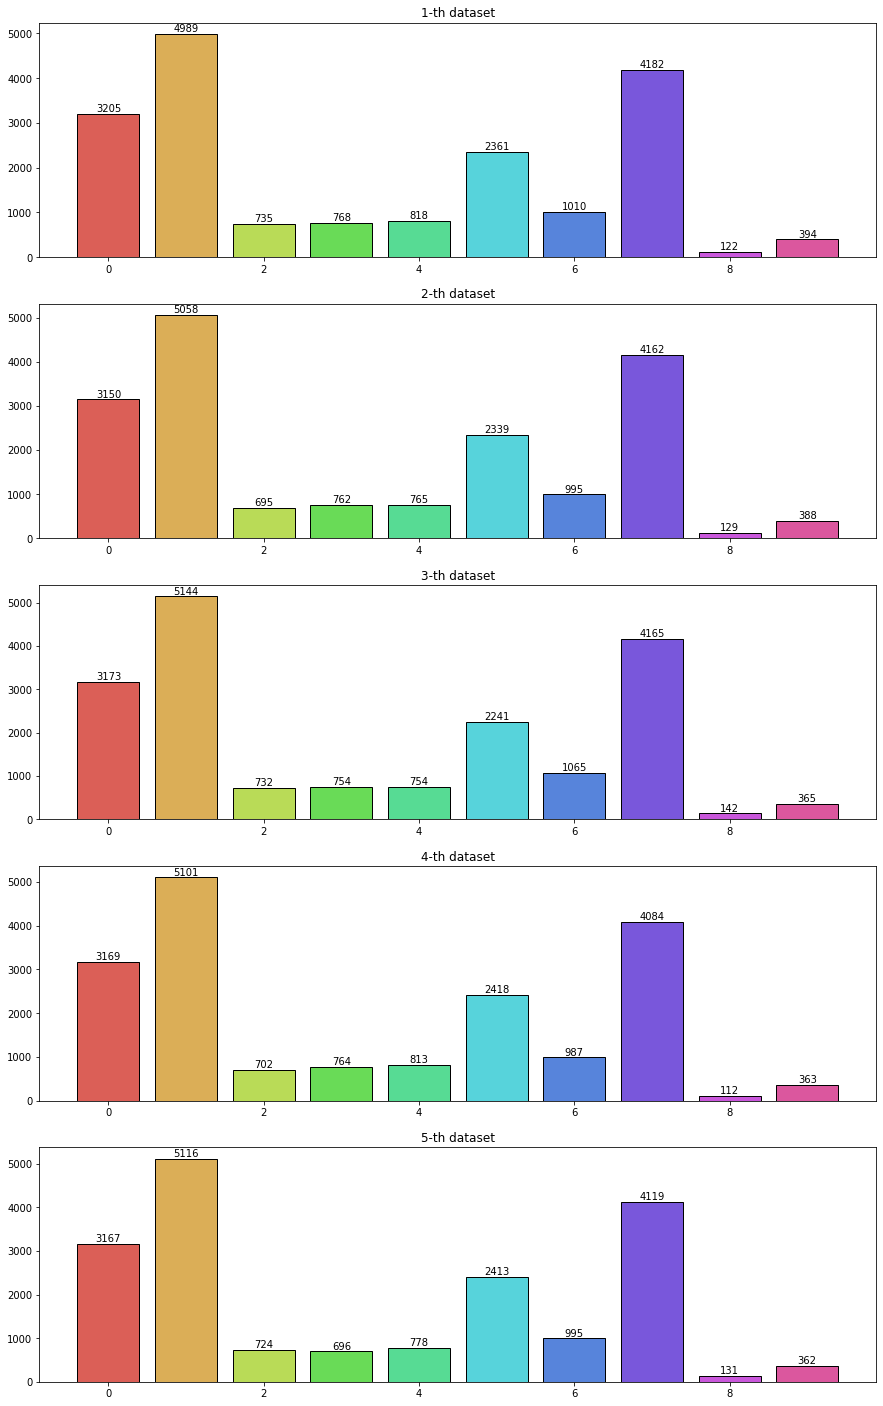

In [225]:
fig,axes = plt.subplots(5,1,figsize=(15,25))
axes = axes.flatten()
colors = sns.color_palette('hls',10) 

for idx,ax in enumerate(axes):
    ax.set_title(f'{idx+1}-th dataset')
    line =ax.bar(list(range(10)),height=label_nums[idx],edgecolor='black',color=colors)
    for label_idx,label_value in enumerate(label_nums[idx]):
        ax.text(label_idx,label_value+50,label_value,ha='center')
#     sns.barplot(x=list(range(10)),y=label_nums[idx],ax=ax,hue=[d['name'] for d in coco['categories']])

#label_nums

## 분류

In [96]:
imgid2annos = [[] for _ in range(len(coco['images']))]
for anno in annotations:
    imgid = anno['image_id']
    imgid2annos[imgid].append(anno)

In [97]:
len(imgid2annos[1]),sum(Y[1])

(8, 8)

In [154]:
os.makedirs('./kfold',exist_ok=True)
root = './kfold'

In [155]:
for idx,(train_index, val_index) in enumerate(mskf.split(X, Y)):
    cv_train_path = os.path.join(root,f'cv_train{idx+1}.json')
    cv_val_path = os.path.join(root,f'cv_val{idx+1}.json')
    cv_train = dict()
    cv_val = dict()

    # train
    cv_train['info'] = coco['info']
    cv_train['licenses'] = coco['licenses']
    cv_train['categories'] = coco['categories']
    
    train_images=[]
    train_annos=[]
    for t_index in train_index:
        train_images.append(X[t_index])
        image_id = X[t_index]['id']
        train_annos +=imgid2annos[image_id]
    
    cv_train['images'] = train_images
    cv_train['annotations'] = train_annos
    
    with open(cv_train_path,'w') as f:
        json.dump(cv_train,f)
    
    # validation
    cv_val['info'] = coco['info']
    cv_val['licenses'] = coco['licenses']
    cv_val['categories'] = coco['categories']
    
    val_images=[]
    val_annos=[]
    for v_index in val_index:
        val_images.append(X[v_index])
        image_id = X[v_index]['id']
        val_annos +=imgid2annos[image_id]
    
    cv_val['images'] = val_images
    cv_val['annotations'] = val_annos
    
    with open(cv_val_path,'w') as f:
        json.dump(cv_val,f)
